
# Churned Customers Behaviour Prediction


### Através do conjuntos de dados de clientes desistentes, disponibilizado pela IBM, é póssivel analisar os dados mais relevantes para prever o comportamento dos clientes e desenvolver programas focados na retenção dos mesmos.

O conjunto de dados inclui informações sobre:

- ***Churn:*** Clientes que saíram no último mês
- **Serviços que cada cliente assinou:** telefone, Múltiplas linhas telefônicas, internet, segurança online, backup online, proteção de dispositivo, suporte técnico e streaming de TV e filmes
- **Informações da conta do cliente:** há quanto tempo ele é cliente, contrato, método de pagamento, faturamento sem papel, cobranças mensais e cobranças totais
- **Informações demográficas sobre clientes:** sexo, faixa etária e se eles têm parceiros e dependentes

***

<img src="https://miro.medium.com/max/1200/1*WqId29D5dN_8DhiYQcHa2w.png"  title="Churned Customers Behaviour Prediction" />

***

# Código

In [1]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def create_description(df):
    d = {'column': [], 
         'value/type': []}

    for c in df.columns:
        if df[c].dtype=='O' and df[c].describe()[1]<=10:
            d['value/type'] += [set(df[c])]
        else:
            d['value/type'] += [df[c].dtype]
        d['column'] += [c]       

    return pd.DataFrame(data=d)

In [4]:
def convert_str_to_float(value):
    try:
        return float(value)
    except Exception:
        return np.nan

In [5]:
def set_tenure_group(value):
    for i in range(12,60,12):
        if value <= i:
            return str(i-12)+'-'+str(i)
    return 'qt-60'

In [6]:
def heatmap(df):
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    fig, ax = plt.subplots(figsize=(20,20)) 
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title("PPS matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    return ax

In [7]:
def validate_model(X, y, clf, quite = False):
    
    X = np.array(X)
    y = np.array(y)
    
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring = 'recall')
    
    if quite == False:
        print('scores: ', scores)
        print('Recall: {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std()))
        
    return scores.mean()

# Análise dos dados

In [8]:
telco_customer_churn = pd.read_csv('telco_customer_churn.csv')

In [9]:
telco_customer_churn

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [ ]:
#profile = pandas_profiling.ProfileReport(telco_customer_churn, title='Churned Customers Behaviour Prediction',html={'style':{'full_width':True}})
#profile.to_file(output_file="Churned_Customers_Behaviour_Prediction_Report_2.html")

In [10]:
telco_customer_churn = telco_customer_churn.drop(columns=['customerID'])

In [11]:
df_description = create_description(telco_customer_churn)
df_description

,column,value/type
0,gender,"{Male, Female}"
1,SeniorCitizen,int64
2,Partner,"{Yes, No}"
3,Dependents,"{Yes, No}"
4,tenure,int64
5,PhoneService,"{Yes, No}"
6,MultipleLines,"{Yes, No phone service, No}"
7,InternetService,"{No, DSL, Fiber optic}"
8,OnlineSecurity,"{Yes, No, No internet service}"
9,OnlineBackup,"{Yes, No, No internet service}"


In [13]:
#telco_customer_churn['TotalCharges'] = telco_customer_churn['TotalCharges'].replace({" ":'0'})
#telco_customer_churn['TotalCharges'] = telco_customer_churn['TotalCharges'].astype(float)
telco_customer_churn['TotalCharges'] = telco_customer_churn['TotalCharges'].apply(convert_str_to_float)
telco_customer_churn['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

In [14]:
totalcharges_median = telco_customer_churn['TotalCharges'].median()

In [15]:
telco_customer_churn['TotalCharges'].fillna(totalcharges_median,inplace=True)

<AxesSubplot:xlabel='tenure', ylabel='Count'>

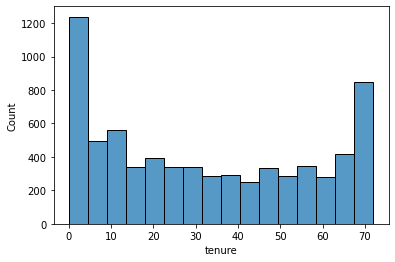

In [58]:
sns.histplot(data=telco_customer_churn, x="tenure")

<AxesSubplot:xlabel='gender', ylabel='count'>

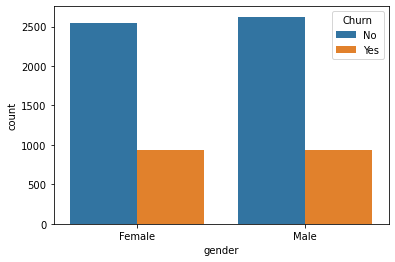

In [15]:
sns.countplot(x ='gender', hue='Churn', data=telco_customer_churn)

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

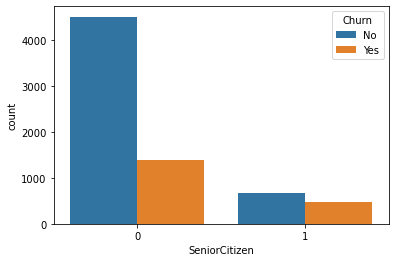

In [180]:
sns.countplot(x ='SeniorCitizen', hue='Churn', data=telco_customer_churn)

<AxesSubplot:xlabel='Partner', ylabel='count'>

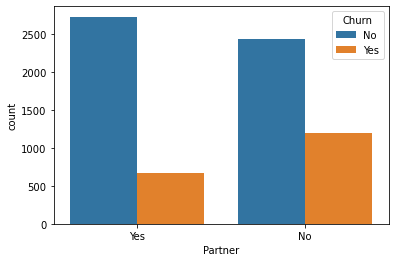

In [181]:
sns.countplot(x ='Partner', hue='Churn', data=telco_customer_churn)

<AxesSubplot:xlabel='Dependents', ylabel='count'>

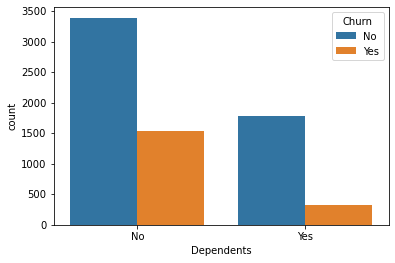

In [59]:
sns.countplot(x ='Dependents', hue='Churn', data=telco_customer_churn)

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

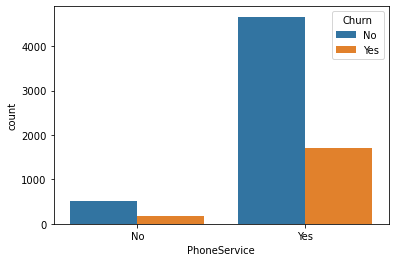

In [183]:
sns.countplot(x ='PhoneService', hue='Churn', data=telco_customer_churn)

<AxesSubplot:xlabel='Contract', ylabel='count'>

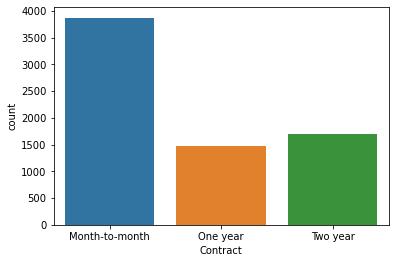

In [44]:
sns.countplot('Contract', data = telco_customer_churn)

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

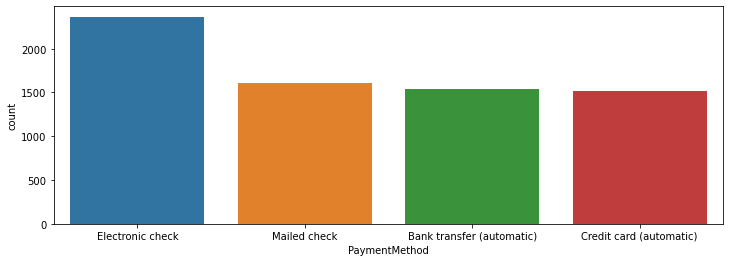

In [36]:
fig, ax = plt.subplots(figsize = (12, 4))
sns.countplot('PaymentMethod', data = telco_customer_churn,ax=ax)

<AxesSubplot:xlabel='Contract', ylabel='count'>

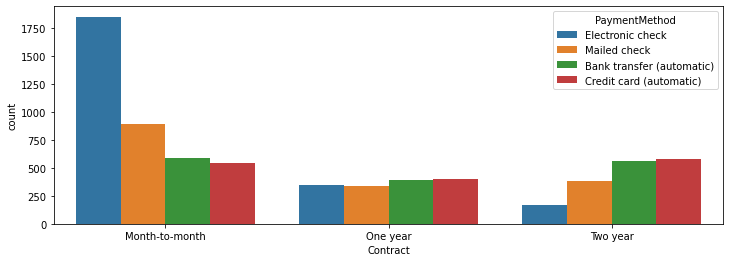

In [83]:
fig, ax = plt.subplots(figsize = (12, 4))
sns.countplot('Contract',hue='PaymentMethod', data = telco_customer_churn,ax=ax)

<AxesSubplot:xlabel='Churn', ylabel='count'>

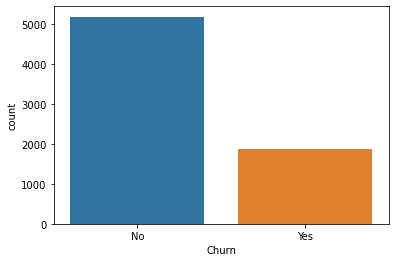

In [45]:
sns.countplot('Churn', data = telco_customer_churn)

<AxesSubplot:title={'center':'PPS matrix'}, xlabel='feature', ylabel='target'>

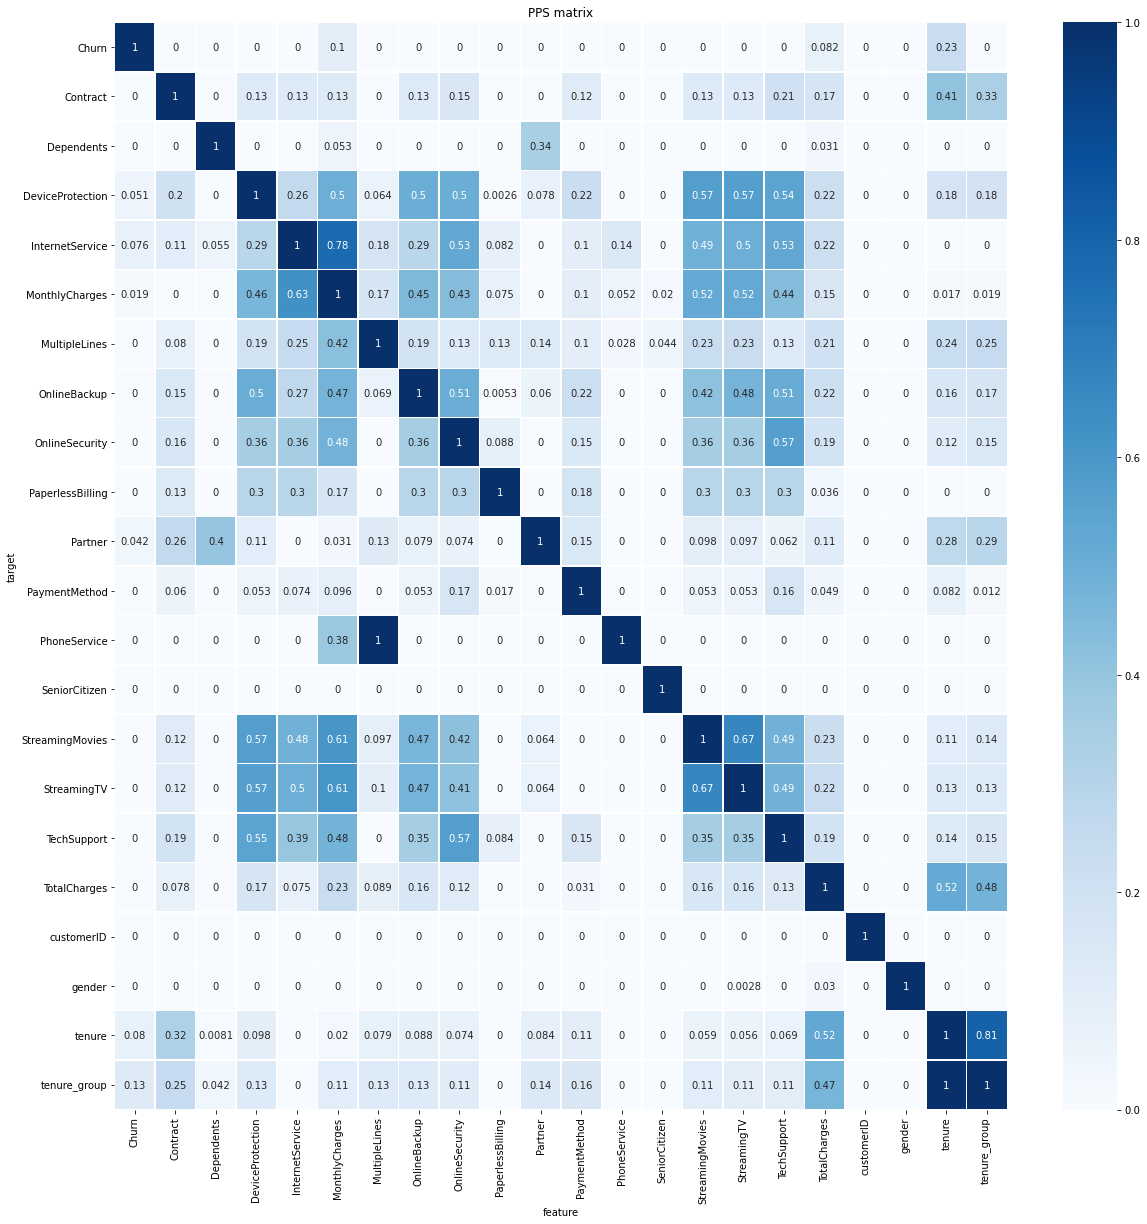

In [184]:
matrix = pps.matrix(telco_customer_churn)
heatmap(matrix)

# Pré processamento de dados

In [16]:
binary_cols = telco_customer_churn.nunique()[telco_customer_churn.nunique() == 2].keys().tolist()
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [17]:
num_cols = [c for c in telco_customer_churn.select_dtypes(['int', 'float', 'int64', 'float64']).columns.tolist() if c not in binary_cols]
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [18]:
cat_cols = [c for c in telco_customer_churn.columns.tolist() if c not in binary_cols + num_cols]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [20]:
df_churn = telco_customer_churn.copy()

lblencoder = LabelEncoder()
for b in binary_cols:
    df_churn[b] = lblencoder.fit_transform(df_churn[b])
    
df_churn = pd.get_dummies(df_churn, columns = cat_cols)

df_churn

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990.50,0,...,0,0,1,0,1,0,0,0,0,1
7039,0,0,1,1,72,1,1,103.20,7362.90,0,...,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,11,0,1,29.60,346.45,0,...,1,0,0,1,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,74.40,306.60,1,...,1,0,0,1,0,0,0,0,0,1


In [137]:
df_churn.corr()['Churn'].abs().sort_values(ascending=False)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
tenure                                     0.352229
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
Contract_Two year                          0.302253
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
TechSupport_No internet service            0.227890
InternetService_No                         0.227890
OnlineSecurity_No internet service         0.227890
DeviceProtection_No internet service       0.227890
OnlineBackup_No internet service           0.227890
StreamingTV_No internet service            0.227890
StreamingMovies_No internet service        0.227890
TotalCharges                               0.199037
MonthlyCharges                             0.193356
PaperlessBil

In [142]:
best_columns = list(df_churn.corr()['Churn'].loc[df_churn.corr()['Churn'].abs() >=df_churn.corr()['Churn'].abs().mean()].index)

In [143]:
X = df_churn[best_columns].drop('Churn', axis = 1)
y = df_churn['Churn']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    shuffle = True,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [145]:
X_train

,tenure,TotalCharges,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineBackup_No,OnlineBackup_No internet service,DeviceProtection_No,DeviceProtection_No internet service,TechSupport_No,TechSupport_No internet service,StreamingTV_No internet service,StreamingMovies_No internet service,Contract_Month-to-month,Contract_Two year,PaymentMethod_Electronic check
6661,72,3784.00,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4811,4,193.60,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
2193,56,1238.65,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0
1904,56,5124.60,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1
6667,9,723.40,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,63,6590.80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1488,1,51.25,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
6303,71,7707.70,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2710,24,482.80,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0


In [146]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [147]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

y_train_rus.value_counts()

1    1402
0    1402
Name: Churn, dtype: int64

# Ranking dos Algoritmos

In [148]:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
mlp = MLPClassifier()
knn = KNeighborsClassifier()
gpc = GaussianProcessClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()

model = []
recall = []

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm, mlp,knn,gpc,abc,gnb):
    model.append(clf.__class__.__name__)
    recall.append(validate_model(X_train_rus, y_train_rus, clf, quite = True))
    
pd.DataFrame(data = recall, index = model, columns = ['Recall']).sort_values(by=['Recall'],ascending=False)

[13:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Recall
GaussianNB,0.896568
AdaBoostClassifier,0.813144
LogisticRegression,0.795300
SVC,0.785308
SGDClassifier,0.780343
LGBMClassifier,0.778188
MLPClassifier,0.764652
GaussianProcessClassifier,0.763935
XGBClassifier,0.759647
KNeighborsClassifier,0.755363


In [138]:
gnb = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(gnb, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.913677811550152 para {'var_smoothing': 1.0}


In [139]:
abc = AdaBoostClassifier()

param_grid = {
    #'n_estimator':[100,200],
    'learning_rate':[0.1,0.001,0.01,0.2,0.5]
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(abc, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8851671732522796 para {'learning_rate': 0.001}


In [101]:
lr = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C':[0.001,0.009,0.01,0.09,1,5,10,25]
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(lr, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8281357649442755 para {'C': 0.001, 'penalty': 'l2'}


In [115]:
svc = SVC()

param_grid = {
    'kernel':['linear','rbf','poly']
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(svc, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8337791286727457 para {'kernel': 'linear'}


In [35]:
svc = SVC(kernel='linear')

param_grid = {
    'C':[1,10,100,1000]
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(svc, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8223505572441743 para {'C': 10}


In [116]:
svc = SVC(kernel='linear',C=10)

param_grid = {
    'gamma':[1,0.1,0.001,0.0001]
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(svc, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8337791286727457 para {'gamma': 1}


In [102]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors':[3,5,7,9],
    'p':[1,2],
    'weights':['uniform', 'distance']
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(knn, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7796149949341439 para {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [103]:
knn = KNeighborsClassifier(n_neighbors=9, p=2, weights='uniform')

param_grid = {
    'leaf_size':list(range(1,50))
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(knn, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7860891590678825 para {'leaf_size': 3}


In [107]:
sgdc = SGDClassifier()

param_grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(sgdc, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8852127659574469 para {'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l1'}


# Melhor Algoritmo

In [140]:
best_classifier = GaussianNB(var_smoothing= 1.0)
best_classifier.fit(X_train_rus, y_train_rus)

X_test = scaler.transform(X_test)
y_pred = best_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.47      0.62      1294
           1       0.38      0.92      0.54       467

    accuracy                           0.59      1761
   macro avg       0.66      0.69      0.58      1761
weighted avg       0.79      0.59      0.60      1761



<AxesSubplot:xlabel='Predito', ylabel='Real'>

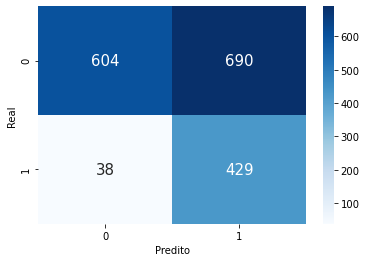

In [141]:
conf = pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'])

sns.heatmap(conf, annot=True, fmt=".0f", annot_kws={"size":15}, cmap=plt.cm.Blues)